<h1 align="center"> Adapted from "Volume 2: The Fourier Transform".</h1>

    Darian Comsa

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import fft, ifft, fft2, ifft2
from scipy import linalg as la
from scipy.signal import fftconvolve as fftc
import IPython
import imageio
from scipy import linalg as la
from scipy import sparse
from scipy.sparse import linalg as spla

In [4]:
plt.rcParams["figure.dpi"] = 300             # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3)      # Change plot size / aspect (you may adjust this).

In [5]:
def lagrange(xint, yint, points):
    """Find an interpolating polynomial of lowest degree through the points
    (xint, yint) using the Lagrange method and evaluate that polynomial at
    the specified points.

    Parameters:
        xint ((n,) ndarray): x values to be interpolated.
        yint ((n,) ndarray): y values to be interpolated.
        points((m,) ndarray): x values at which to evaluate the polynomial.

    Returns:
        ((m,) ndarray): The value of the polynomial at the specified points.
    """
    # p(x) = Summation(y_j *  L_j(x), (j,1,n))
    # L_j(x) = Product(x - x_k, (k,1,n,k!=j)) /
    #                     Product(x_j - x_k, (k,1,n,k!=j))

    # given the x points, compute the denominator of each L_j

    L_j_x = []
    n = xint.size
    for j,xj in enumerate(xint): # for each Lagrange basis function
        denom = 1
        # get a column of points for each other interpolation point
        mpoints = np.vstack([points]*(n-1)).T
        # get the other interpolation points
        x_ks = np.delete(xint, j)
        denom = np.prod(xj - x_ks)
        mpoints = np.prod(mpoints - x_ks, axis=1)
        L_j_x.append(mpoints / denom)
    L_j_x = np.array(L_j_x)

    # L_j_denom = np.array([np.prod([xj - xk for xk in np.delete(xint,i)]) \
    #                 for i,xj in enumerate(xint)])
    # # Compute each L_j(points)
    # L_j_x = np.array([np.prod([points - xk \
    #             for xk in np.delete(xint, j)], axis=0) / denom \
    #             for j,denom in enumerate(L_j_denom)])

    # return p(points)

    # transpose for array broadcasting, then transpose again to get the sum
    p_x = np.sum((L_j_x.T * yint), axis=1)
    return p_x

In [6]:
class SoundWave(object):
    """A class for working with digital audio signals.
    
    Attributes:
        rate (int): the sample rate of the sound.
        samples ((n,) ndarray): NumPy array of samples.
    """

    # Problem 1.1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        self.rate = rate
        self.samples = samples

    # Problems 1.1 and 1.7
    def plot(self, find_dft=False):
        """Plot the graph of the sound wave (time versus amplitude)."""
        # plot the sound wave
        num_s = len(self.samples)
        if num_s == 0:
            raise ValueError("There are no sample points.")
        secs = num_s / self.rate
        samptimes = np.linspace(0, secs, num_s, endpoint=False)
#         axes_lims = [0, secs, -32768, 32767]
        
        if find_dft:
            dft_abs = np.abs(fft(self.samples))[:num_s//2]
            domain = np.arange(num_s//2) / num_s * self.rate
            
            plt.subplot(121)
            plt.plot(domain, dft_abs)
            plt.title("Frequency Domain")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            plt.subplot(122)
            
        plt.plot(samptimes, self.samples)
        plt.title("Sound Wave")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude of Samples")
#         plt.axis(axes_lims)
        
        plt.show()

    # Problem 1.2
    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before 
        exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
            force (bool): default is False. If force, will rescale the samples
        """
        # check if type is numpy.int16 or if force==True
        if type(self.samples[0]) != np.int16 or force:
            # print(type(self.samples[0]))
            scaled_samples = np.int16((
                self.samples * 32767. / np.max(abs(self.samples))).real)
        else:
            scaled_samples = self.samples.real
        # write the file
        wavfile.write(filename, self.rate, scaled_samples)
    
    # Problem 1.4
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        # add samples
        sw = SoundWave(self.rate, self.samples + other.samples)
        
        return sw

    # Problem 1.4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        # append samples
        sw = SoundWave(self.rate, np.hstack((self.samples, other.samples)))
        
        return sw
    
    # Problem 2.1
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using 
        circular convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        self_len = len(self.samples)
        other_len = len(other.samples)
        # pad the lengths
        if self_len < other_len:
            n_self = np.hstack((self.samples, np.zeros(other_len - self_len)))
            n_other = other.samples
        else:
            n_self = self.samples
            n_other = np.hstack((other.samples, np.zeros(self_len - other_len)))
        new_samples = ifft(fft(n_self) * fft(n_other)).real
        sw = SoundWave(self.rate, new_samples)
        
        return sw

    # Problem 2.2
    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using 
        linear convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        self_len = len(self.samples)
        other_len = len(other.samples)
        comb_len = self_len + other_len
        len_pwr = 1
        while len_pwr < comb_len - 1:
            len_pwr *= 2
        # adjust the length
        n_self = np.hstack((self.samples, np.zeros(len_pwr - self_len)))
        n_other = np.hstack((other.samples, np.zeros(len_pwr - other_len)))
        new_samples = ifft(fft(n_self) * fft(n_other)).real
        sw = SoundWave(self.rate, new_samples[:comb_len])
        
        return sw

    # Problem 2.4
    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT. 

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher boound of the frequency range to zero out.
        """
        n = len(self.samples)
        klo = int(low_freq * n / self.rate)
        khi = int(high_freq * n / self.rate) + 1
        dft = fft(self.samples)
        # use fancy indexing
        cutout = np.hstack( (np.arange(klo, khi), np.arange(n-khi, n-klo)) )
        dft[cutout] = 0
        self.samples = ifft(dft).real
        
    def boost(self, low_freq, high_freq, boost=2.):
        """Boost the frequencies in the given range using the DFT.
        
        Parameters:
            low_freq (float): Lower bound of the frequency range to boost.
            high_freq (float): Higher boound of the frequency range to boost.
            boost (float): the amount to boost the range
        """
        n = len(self.samples)
        klo = int(low_freq * n / self.rate)
        khi = int(high_freq * n / self.rate) + 1
        dft = fft(self.samples)
        # boost the coefficients
        booster = np.hstack( (np.arange(klo, khi), np.arange(n-khi, n-klo)) )
        dft[booster] *= boost
        self.samples = ifft(dft).real
        
    def __sub__(self, other):
        """Adjust self by frequencies unique to other."""
        # take the dfts of each and subtract out the frequencies
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        self_len = len(self.samples)
        other_len = len(other.samples)
        comb_len = self_len + other_len
        len_pwr = 1
        while len_pwr < comb_len - 1:
            len_pwr *= 2
        # pad lengths
        n_self = np.hstack((self.samples, np.zeros(len_pwr - self_len)))
        n_other = np.hstack((other.samples, np.zeros(len_pwr - other_len)))
        sdft = fft(n_self)
        diff_dft = np.abs(sdft - fft(n_other))
        new_samples = ifft(sdft * diff_dft).real
        sw = SoundWave(self.rate, new_samples[:comb_len])
        
        return sw

### Problem 1.3

- Implement `generate_note()`.
- Use `generate_note()` to create an A tone that lasts for two seconds. Embed it in the notebook.

In [7]:
def hit_sample(n):
    """Return positive of a normal distribution of points."""
    domain = np.linspace(0, 5, n)
    return 1/(np.sqrt(2*np.pi))*np.exp(-domain**2/(2))

In [8]:
# def isolate(freq, samples, sigma=1.):
#     """Bring out frequencies distributed near the input frequency.

#     Parameters:
#         freq (float): frequency to be mean of normal distribution
#         sigma (float): standard deviation of boosted frequencies
#     """
#     rate = 44100
#     n = len(samples)
#     sigma *= n/4400*np.sqrt(freq)
#     kmean = int(freq * n / rate)
#     n_odd = (n % 2 != 0)
#     domain = 0
#     if n_odd:
#         domain = np.arange(0, n//2 + 1)
#     else:
#         domain = np.arange(0, n//2)
#     normal = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(domain-kmean)**2/(2*sigma**2))
#     norm_sym = 0
#     if n_odd:
#         norm_sym = np.hstack((normal, normal[:0:-1]))
#     else:
#         norm_sym = np.hstack((normal, normal[::-1]))
#     dft = fft(samples) * norm_sym
#     return ifft(dft).real

In [9]:
class Compose(object):
    """A class to generate music from instances of the SoundWave class using 
    the notes input.
    
    Attributes:
        tempo (float): how many beats per minute
        tracks (list): list of lists, each starting with the instrument,
                with tuples of notes of the form note=("tone",...,"tone", beats)
        soundwave (SoundWave): the rate and samples stored in a SoundWave object
        
    Example:
        tempo = 144
        tracks = [
                ['sine', ('a4',1), ('c#5',1), ('e5',2), ('a4','c#5','e5',4) ],
                ['sine_3', ('f#3',1),('g#3',1),('a3',2),('a3',4)]
                ]
    Notice:
        Tones include [a,b,c,d,e,f,g]; # is accepted before the octave number.
        The number following is the octave number.
        'c4' is middle C, a4 is the next A above c4 (A440).
        If the tracks are not of the same size, they will be padded at the end.
    """

    def __init__(self, tempo, tracks):
        """Generate an instance of the SoundWave class that uses the notes input.
        """
                
        hs = 2**(1 / 12) # half step is 12 root of 2 up or down
        # beats per second is tempo / 60
        bps = tempo / 60.
        scale = {'c':0, 'd':2, 'e':4, 'f':5, 'g':7, 'a':9, 'b':11}

        music = generate_note(0,0)
        for notes in tracks:
            instrument = notes[0]
            track = generate_note(0,0)
            for note in notes[1:]:
                tones = note[:-1]
                beats = note[-1]
                # Check if has other info (i.e. voice)
                if type(beats)==tuple:
                    other = beats[1]
                    beats = beats[0]
                else:
                    other = None
                # parse each tone
                sw = generate_note(0, beats / bps, instrument, other)
                if len(tones) != 0:
                    for tone in tones:
                        n = scale[tone[0]]
                        if tone[1] == '#':
                            n += 1
                            n += 12*(float(tone[2]) - 4)
                        else:
                            n += 12*(float(tone[1]) - 4)
                        n -= 9
                        sw += generate_note(440 * hs**n, beats / bps, instrument, other)
                track = track >> sw
            mml = len(music.samples)
            ttl = len(track.samples)
            if mml < ttl:
                # pad music
                music.samples = np.hstack((music.samples, np.zeros(ttl - mml) ))
            else:
                # make track longer
                track.samples = np.hstack((track.samples, np.zeros(mml - ttl) ))
            music = music + track

        self.soundwave = music

    # TODO: instead of starting the sine wave over again each time, keep track of 
    #         where the phase is and start the next sine wave there...
    #         but how do I differentiate a note that is held and a repeated note?
    #         should I put a character before or after the note name?
    #         I think putting a tied note character before might help;
    #         it will generalize to note articulation...

In [10]:
def get_formant_image(vwl_fs, height=5, var=1.1):
    """Takes formants and returns formant graph image.
    Height adjusts the slope height.
    Var adjusts the mountain width.
    """
    # add many sine waves to approximate the formant
    # the loudness of the formants is approximated by joint parabolas 
    # (like simpson's rule), being functions of formant points f1,f2,f3,f12...
    # e.x.:
    # the points y(f1) = 8*(f1 - 3500)**2 / 3500**2
    #            y(f2) = 8*(f2 - 3500)**2 / 3500**2
    #            y{f12} = 100 * y(f1) / (f2 - f1)
    #            y(f23) = 50 * y(f2) / (f3 - f2)
    # x = [min[]/2 - f1, 0, 
    #      f1 - min[(f12-f1), f1]/2, f1, f1 + min[]/2, f12, 
    #      f2 - min[(f2-f12), (f23-f2)]/2, f2, f2 + min[]/2, f23,
    #      f3 - min[(f3-f23), (3500-f3)]/2, f3, f3 + min[]/2, 
    #      3500, 3500 + (3500 - (f3 + min[]/2))]
    # y = [y(f1)/3, 0, 
    #      y(f1)/3, y(f1), y(f1)/3, y(f12), 
    #      y(f2)/3, y(f2), y(f2)/3, y(f23), 
    #      y(f3)/3, y(f3), y(f3)/3,
    #      0, y(f3)/3]

    # Make formants
    f1, f2, f3 = vwl_fs[0], vwl_fs[1], vwl_fs[2]
    y1 = lambda x: 1*(x - 3500)**2 / 3500**2 + 1
    y2 = lambda x1, x2: min([y1(x1), y1(x2)]) / 3 * (3500 - (x2 - x1)) / 3500

    # Set y values of f1,f2,f3,f12...
    yf1, yf2, yf3 = y1(f1), y1(f2), y1(f3)
#     print('yf1, yf2, yf3:', yf1,yf2,yf3)
    f12 = (f1 + f2)/2 + abs(yf1 - yf2)/max([yf1,yf2])*(f2 - f1)/2
    f23 = (f2 + f3)/2 + abs(yf2 - yf3)/max([yf2,yf3])*(f3 - f2)/2
    yf12, yf23 = y2(f1, f2), y2(f2, f3)
    # Set x values and y values
#     print('f1,f2,f3:',f1,f2,f3)
#     print('f12,f23:',f12,f23)

    min1 = min([(f12-f1), f1, 300])/var
    min2 = min([(f2-f12), (f23-f2), 300])/var
    min3 = min([(f3-f23), (3500-f3), 300])/var/3
    xx = np.array([min1 - f1, 0, 
         f1 - min1, f1, f1 + min1, f12, 
         f2 - min2, f2, f2 + min2, f23,
         f3 - min3, f3, f3 + min3, 
         3500, 7000 - (f3 + min3)])
    yf11 = (yf1 + yf1*f1/f2)/height
    yf22 = (yf2 + yf2*f1/f2)/height
    yy = np.array([yf11, yf1, 
         yf11, yf1, yf11, yf12, 
         yf22, yf2, yf22, yf23, 
         yf3/3, yf3, yf3/3,
         0, yf3/3])
    domain = np.empty(0)
    image = np.empty(0)

    n_pts = 3
    for i in range(0,14,n_pts-1):
        xint = xx[i:i+n_pts]
        yint = yy[i:i+n_pts]
        domain = np.linspace(xint[0], xint[-1], int(1000*(xint[-1]-xint[0])), endpoint=False)
        domain[domain < 0] = domain[domain > 3500] = -1
        domain = domain[domain > 0]
        image = np.append(image, lagrange(xint, yint, domain))
#     print(image.shape)
#     print('min, max:', min(image), max(image))
#     plt.plot(np.arange(len(image)), image)
#     plt.show()
#     image[image<0] = 0
#     image = image[199:]
    return image

# Set up formant dictionary
vwl1 = [r'i',r'y',r'e',r'o/',r'eps',r'oe',r'a',r'OE',r'\a',r'\/a',
          r'^',r'\/c',r'gam',r'o',r'\/m',r'u']
vwl1_f1 = [240,235,390,370,610,585,850,
            820,750,700,600,500,460,360,300,250]
vwl1_f2 = [2400,2100,2300,1900,1900,1710,1610,
            1530,940,760,1170,700,1310,640,1390,595]
vwl1_dict = {v:(f1,f2,(f2 + 4000)/2) for v,f1,f2 in zip(vwl1, vwl1_f1, vwl1_f2)}
vwl2 =    ['ee','ih','ey','eh','aa','ah','aw','oh','oo','uu','uh','er']
vwl2_f1 = [ 280, 370, 426, 610, 860, 838, 620, 567, 480, 328, 683, 514]
vwl2_f2 = [2322,2090,1899,1850,1552,1173, 827, 910,1122, 807,1310,1319]
vwl2_dict = {v:(f1,f2,(f2 + 4000)/2) for v,f1,f2 in zip(vwl2, vwl2_f1, vwl2_f2)}

formant_images = {v:get_formant_image(vfs) for v,vfs in zip(vwl2,vwl2_dict.values())}

In [11]:
for ke,im in zip(formant_images.keys(),formant_images.values()):
    print(ke)
    
#     plt.plot(np.arange(len(im)), im)
#     plt.suptitle("1000*Frequency vs Intensity")
#     plt.show()

ee
ih
ey
eh
aa
ah
aw
oh
oo
uu
uh
er


In [12]:
# phase is not implemented yet (sliding/smooth/disjoint sine waves...)
def generate_note(frequency, duration, instrument='sine', other=None, phase=0):
    """Generate an instance of the SoundWave class corresponding to 
    the desired soundwave. Uses sample rate of 44100 Hz.
    
    Parameters:
        frequency (float): The frequency of the desired sound.
        duration (float): The length of the desired sound in seconds.
    
    Returns:
        sound (SoundWave): An instance of the SoundWave class.
    """
    # new_phase = frequency 
    rate = 44100
    num_s = int(rate * duration)
    krand = np.random.rand()
    domain = np.linspace(krand, duration + krand, num_s, endpoint=False)
    pwr = 1
    if instrument[:5] in ('sinep',):
        params = instrument.split('_')
        pwr = int(params[1])
#         if pwr % 2 == 0:
#             frequency /= 2
        instrument = params[0]
    if instrument == 'voice':
        pwr = other
    instruments = {'sine':sine_wave, 'square':square_wave, 
                   'sinep':sinepwr_wave, 'sawtooth':sawtooth_wave,
                   'triangle':triangle_wave, 'snare_hit':snare_hit,
                   'cymbal':cymbal, 'voice':voice
                  }
    voice_function = instruments[instrument]
    
    if frequency != 0:
        samples = voice_function(frequency, domain, pwr)
    else:
        samples = frequency * domain
    if 20 < frequency < 220 and instrument=='sine':
        bass_boost = 6*220 / frequency
        samples *= bass_boost
    sw = SoundWave(rate, samples)
    
    return sw

def sine_wave(frequency, samples, pwr=1):
    """Returns sinusoidal samples unchanged."""
    return np.sin(2*np.pi * frequency * samples)

def square_wave(frequency, samples, pwr=1):
    """Take the sign of the samples and return the square wave."""
    # 0,1,0,-1,0
    return np.sign(sine_wave(frequency, samples))

def sinepwr_wave(frequency, samples, pwr=2):
    """Exponent the samples."""
    samples = sine_wave(frequency, samples)
    if pwr % 2 != 0:
        samples = samples ** pwr
    else:
        samples = (samples + 1) / 2
        samples = samples ** pwr
        samples = 2 * samples - 1
    return samples

def sawtooth_wave(frequency, samples, pwr=1):
    """Turn into sawtooth."""
    samples = samples % (1/frequency)
    mean = max(samples)/2
    return samples - mean

def triangle_wave(frequency, samples, pwr=1):
    """Turn samples into triangle."""
    samples = 2 * np.abs(sawtooth_wave(frequency, samples))
    mean = max(samples)/2
    return samples - mean

def snare_hit(frequency, samples, sigma=1.):
    """Make white noise percussion."""
    n = len(samples)
    hits = np.random.rand(n)
    return hits

def cymbal(frequency, samples, pwr=1):
    """Make white noise percussion."""
    n = len(samples)
    hits = hit_sample(n)
    hits *= np.random.rand(n)
    return 10*hits

def voice(frequency, samples, other):
    """NOT FINISHED. NEEDS CONSONANTS.
    
    Make a voice sample with info from parameter other.
    Formats of other:
    [begin_consonant, main_vowel(, ending_vowel(,s), ending_consonant(,s))]
    or (not finished)
    [formant1, formant2, formant3, begin_consonant, end_consonant, quality]
    """
    if other is None:
        return sine_wave(frequency, samples, other)


    def filter_sound(freq, image, samps):
        """Take a formant image and frequency and return filtered samples."""
        base = np.zeros_like(samps)
        # Take multiples of the frequency (there are n*frequency points).
        for i, vol in enumerate(image[::int(1000*freq)]):
            # Prevent sine wave alignment (add random phase).
            samps_ph = samps + np.random.rand()
            # Divide by index to make higher freqencies softer.
            base += ((vol))*sine_wave(freq*i, samps_ph) / (i+1)
        return base


    # Partition samples for each vowel.
    
    other = list(other)
    if type(other[0])!=str:
        other = ['',other]
    # Compute partition.
    n_s = len(samples)
    MIN_TRANSITION = min([1100, n_s])
    PARTITION_FRAC = 6
    n_o = len(other)
    n_end = n_o - 2
    n_beg = n_o - n_end
#     print('other:',n_beg, n_end)
#     print('n_s // PARTITION_FRAC({}):'.format(PARTITION_FRAC), n_s // PARTITION_FRAC)
    # Choose vowel sample length between 2*MIN and 4400
    VWLS_LEN = min([4*MIN_TRANSITION, max([n_s // PARTITION_FRAC, 2*MIN_TRANSITION])])
    # Check if there are end sounds.
    if n_end:
        n_s_end = VWLS_LEN
        # If too short <3*1100, cut the end consonant.
        if n_s < 3*MIN_TRANSITION:
            n_s_end = 0
            n_end = 0
    else:
        n_s_end = 0
    n_s_beg = n_s - n_s_end
    samps_beg = samples[:n_s_beg]
    samps_end = samples[n_s_beg:]
#     print('samps_beg len:', len(samps_beg))
#     print('samps_end len:', len(samps_end))
    # Get pre-main sounds.
    bcf = other[0]
    if bcf == '':
        n_s_pre = 0
    else:
        n_s_pre = VWLS_LEN
    # Get main vowel formants.
    mvf = other[1]
    # Get ending sounds.
    end = other[2:]


    # Make beginning samples.
    if type(mvf)==str:
        image = formant_images[mvf]
    else:
        image = get_formant_image(mvf)
    base = filter_sound(frequency, image, samps_beg)
    rfade = np.linspace(0, 1, VWLS_LEN//2, endpoint=False)
    if n_s_pre:
#         print('n_s_beg:',n_s_beg)
#         print('n_s_pre:',n_s_pre)
#         print('n_s_pre - VWLS_LEN//2:',n_s_pre - VWLS_LEN//2)
        samps_pre = samps_beg[:n_s_pre]
        if type(bcf)==str:
            image = formant_images[bcf]
        else:
            image = get_formant_image(bcf)
        base_e = filter_sound(frequency, image, samps_pre)
        # Reverse fade start of beginning.
        base_e[:VWLS_LEN//2] *= rfade
        # Transition.
        base[:n_s_pre - VWLS_LEN//2] = 0
        base[n_s_pre - VWLS_LEN//2:n_s_pre] *= rfade
        base_e[-(VWLS_LEN//2):] *= rfade[::-1]
        base[:n_s_pre] += base_e
    else:
        # Reverse fade start of main vowel.
        base[:VWLS_LEN//2] *= rfade
    
#     # Silence the end
#     if n_end:
#         base = np.append(base, np.zeros(n_s_end))

    # Make end samples.
    if n_end:
        # Each ending sound gets partitioned.
        n_s_e = n_s_end // n_end
        # Leftover gets silence
        n_s_left = n_s_end - n_end * n_s_e
#         print('n_s_e:', n_s_e)
#         print('n_s_left:', n_s_left)

        # Each sound gets a transition of fraction length
        n_s_tra = n_s_e // 2
#         print('n_s_tra:',n_s_tra)
#         print('VWLS_LEN//2',VWLS_LEN//2)
        samps_tra = samps_beg[-n_s_tra:]
        blend = np.linspace(0, 1, n_s_tra, endpoint=False)
        for i, evf in enumerate(end):
            trans1 = base[-n_s_tra:]
            samps_e = samps_end[n_s_e*i:n_s_e*(i+1)]
            samps_ev = np.append(samps_tra, samps_e)
            n_s_ev = n_s_tra + n_s_e
            # Get formant image
            if type(evf)==str:
                image = formant_images[evf]
            else:
                image = get_formant_image(evf)
            # Make vowel
            base_e = filter_sound(frequency, image, samps_ev)
            # Make transition
            trans2 = base_e[:n_s_tra]
            base[-n_s_tra:] = trans1*blend[::-1] + trans2*blend
            samps_tra = samps_e[-n_s_tra:]
            # Combine
            base = np.append(base, base_e[n_s_tra:])
        # Fade to silence
        base[-n_s_tra:] *= blend[::-1]
        base = np.append(base, np.zeros(n_s_left))
    else:
        base[-(VWLS_LEN//2):] *= rfade[::-1]
    
#     mn, mx = np.min(base), np.max(base)
#     print(mn, mx)
#     base = 2*(base - mn) / (mx-mn) - 1
#     print(np.min(base), np.max(base))
    
    return base
        
#     sf1 = sine_wave(other[0], samples)
#     sf2 = sine_wave(other[1], samples)
#     sf3 = 0
#     if f3 != 0:
#         sf3 = sine_wave(f3, samples)
#     return 8*base + 4*sf1 + 2*sf2 + sf3

In [13]:
tempo = 600
tracks = [
            ['voice',('f2',(1,('','ee'))), ('f#2',(1,('','ee'))), ('g2',(1,('','ee'))), 
             ('g#2',(1,('','ee'))), ('a2',(1,('','ee'))), ('a#2',(1,('','ee'))), ('b2',(1,('','ee'))), 
             ('c3',(1,('','ee'))), ('c#3',(1,('','ee'))), ('d3',(1,('','ee'))), ('d#3',(1,('','ee'))),
             ('e3',(1,('','ee'))), ('f3',(1,('','ee'))), ('f#3',(1,('','ee'))), ('g3',(1,('','ee'))), 
             ('g#3',(1,('','ee'))), ('a3',(1,('','ee'))), ('a#3',(1,('','ee'))), ('b3',(1,('','ee'))), 
             ('c4',(1,('','ee'))), ('c#4',(1,('','ee'))), ('d4',(1,('','ee'))), ('d#4',(1,('','ee'))),
             ('e4',(1,('','ee'))), ('f4',(1,('','ee'))), ('f#4',(1,('','ee'))), ('g4',(1,('','ee'))), 
             ('g#4',(1,('','ee'))), ('a4',(1,('','ee'))), ('a#4',(1,('','ee'))), ('b4',(1,('','ee'))), 
             ('c5',(1,('','ee'))), ('c#5',(1,('','ee'))), ('d5',(1,('','ee'))), ('d#5',(1,('','ee'))),
             ('e5',(1,('','ee'))), ('f5',(1,('','ee'))),
            ('f2',(1,('','ih'))), ('f#2',(1,('','ih'))), ('g2',(1,('','ih'))), 
             ('g#2',(1,('','ih'))), ('a2',(1,('','ih'))), ('a#2',(1,('','ih'))), ('b2',(1,('','ih'))), 
             ('c3',(1,('','ih'))), ('c#3',(1,('','ih'))), ('d3',(1,('','ih'))), ('d#3',(1,('','ih'))),
             ('e3',(1,('','ih'))), ('f3',(1,('','ih'))), ('f#3',(1,('','ih'))), ('g3',(1,('','ih'))), 
             ('g#3',(1,('','ih'))), ('a3',(1,('','ih'))), ('a#3',(1,('','ih'))), ('b3',(1,('','ih'))), 
             ('c4',(1,('','ih'))), ('c#4',(1,('','ih'))), ('d4',(1,('','ih'))), ('d#4',(1,('','ih'))),
             ('e4',(1,('','ih'))), ('f4',(1,('','ih'))), ('f#4',(1,('','ih'))), ('g4',(1,('','ih'))), 
             ('g#4',(1,('','ih'))), ('a4',(1,('','ih'))), ('a#4',(1,('','ih'))), ('b4',(1,('','ih'))), 
             ('c5',(1,('','ih'))), ('c#5',(1,('','ih'))), ('d5',(1,('','ih'))), ('d#5',(1,('','ih'))),
             ('e5',(1,('','ih'))), ('f5',(1,('','ih'))),
            ('f2',(1,('','ey'))), ('f#2',(1,('','ey'))), ('g2',(1,('','ey'))), 
             ('g#2',(1,('','ey'))), ('a2',(1,('','ey'))), ('a#2',(1,('','ey'))), ('b2',(1,('','ey'))), 
             ('c3',(1,('','ey'))), ('c#3',(1,('','ey'))), ('d3',(1,('','ey'))), ('d#3',(1,('','ey'))),
             ('e3',(1,('','ey'))), ('f3',(1,('','ey'))), ('f#3',(1,('','ey'))), ('g3',(1,('','ey'))), 
             ('g#3',(1,('','ey'))), ('a3',(1,('','ey'))), ('a#3',(1,('','ey'))), ('b3',(1,('','ey'))), 
             ('c4',(1,('','ey'))), ('c#4',(1,('','ey'))), ('d4',(1,('','ey'))), ('d#4',(1,('','ey'))),
             ('e4',(1,('','ey'))), ('f4',(1,('','ey'))), ('f#4',(1,('','ey'))), ('g4',(1,('','ey'))), 
             ('g#4',(1,('','ey'))), ('a4',(1,('','ey'))), ('a#4',(1,('','ey'))), ('b4',(1,('','ey'))), 
             ('c5',(1,('','ey'))), ('c#5',(1,('','ey'))), ('d5',(1,('','ey'))), ('d#5',(1,('','ey'))),
             ('e5',(1,('','ey'))), ('f5',(1,('','ey'))),
            ('f2',(1,('','eh'))), ('f#2',(1,('','eh'))), ('g2',(1,('','eh'))), 
             ('g#2',(1,('','eh'))), ('a2',(1,('','eh'))), ('a#2',(1,('','eh'))), ('b2',(1,('','eh'))), 
             ('c3',(1,('','eh'))), ('c#3',(1,('','eh'))), ('d3',(1,('','eh'))), ('d#3',(1,('','eh'))),
             ('e3',(1,('','eh'))), ('f3',(1,('','eh'))), ('f#3',(1,('','eh'))), ('g3',(1,('','eh'))), 
             ('g#3',(1,('','eh'))), ('a3',(1,('','eh'))), ('a#3',(1,('','eh'))), ('b3',(1,('','eh'))), 
             ('c4',(1,('','eh'))), ('c#4',(1,('','eh'))), ('d4',(1,('','eh'))), ('d#4',(1,('','eh'))),
             ('e4',(1,('','eh'))), ('f4',(1,('','eh'))), ('f#4',(1,('','eh'))), ('g4',(1,('','eh'))), 
             ('g#4',(1,('','eh'))), ('a4',(1,('','eh'))), ('a#4',(1,('','eh'))), ('b4',(1,('','eh'))), 
             ('c5',(1,('','eh'))), ('c#5',(1,('','eh'))), ('d5',(1,('','eh'))), ('d#5',(1,('','eh'))),
             ('e5',(1,('','eh'))), ('f5',(1,('','eh'))),
            ('f2',(1,('','aa'))), ('f#2',(1,('','aa'))), ('g2',(1,('','aa'))), 
             ('g#2',(1,('','aa'))), ('a2',(1,('','aa'))), ('a#2',(1,('','aa'))), ('b2',(1,('','aa'))), 
             ('c3',(1,('','aa'))), ('c#3',(1,('','aa'))), ('d3',(1,('','aa'))), ('d#3',(1,('','aa'))),
             ('e3',(1,('','aa'))), ('f3',(1,('','aa'))), ('f#3',(1,('','aa'))), ('g3',(1,('','aa'))), 
             ('g#3',(1,('','aa'))), ('a3',(1,('','aa'))), ('a#3',(1,('','aa'))), ('b3',(1,('','aa'))), 
             ('c4',(1,('','aa'))), ('c#4',(1,('','aa'))), ('d4',(1,('','aa'))), ('d#4',(1,('','aa'))),
             ('e4',(1,('','aa'))), ('f4',(1,('','aa'))), ('f#4',(1,('','aa'))), ('g4',(1,('','aa'))), 
             ('g#4',(1,('','aa'))), ('a4',(1,('','aa'))), ('a#4',(1,('','aa'))), ('b4',(1,('','aa'))), 
             ('c5',(1,('','aa'))), ('c#5',(1,('','aa'))), ('d5',(1,('','aa'))), ('d#5',(1,('','aa'))),
             ('e5',(1,('','aa'))), ('f5',(1,('','aa'))),
            ('f2',(1,('','ah'))), ('f#2',(1,('','ah'))), ('g2',(1,('','ah'))), 
             ('g#2',(1,('','ah'))), ('a2',(1,('','ah'))), ('a#2',(1,('','ah'))), ('b2',(1,('','ah'))), 
             ('c3',(1,('','ah'))), ('c#3',(1,('','ah'))), ('d3',(1,('','ah'))), ('d#3',(1,('','ah'))),
             ('e3',(1,('','ah'))), ('f3',(1,('','ah'))), ('f#3',(1,('','ah'))), ('g3',(1,('','ah'))), 
             ('g#3',(1,('','ah'))), ('a3',(1,('','ah'))), ('a#3',(1,('','ah'))), ('b3',(1,('','ah'))), 
             ('c4',(1,('','ah'))), ('c#4',(1,('','ah'))), ('d4',(1,('','ah'))), ('d#4',(1,('','ah'))),
             ('e4',(1,('','ah'))), ('f4',(1,('','ah'))), ('f#4',(1,('','ah'))), ('g4',(1,('','ah'))), 
             ('g#4',(1,('','ah'))), ('a4',(1,('','ah'))), ('a#4',(1,('','ah'))), ('b4',(1,('','ah'))), 
             ('c5',(1,('','ah'))), ('c#5',(1,('','ah'))), ('d5',(1,('','ah'))), ('d#5',(1,('','ah'))),
             ('e5',(1,('','ah'))), ('f5',(1,('','ah'))),
            ('f2',(1,('','aw'))), ('f#2',(1,('','aw'))), ('g2',(1,('','aw'))), 
             ('g#2',(1,('','aw'))), ('a2',(1,('','aw'))), ('a#2',(1,('','aw'))), ('b2',(1,('','aw'))), 
             ('c3',(1,('','aw'))), ('c#3',(1,('','aw'))), ('d3',(1,('','aw'))), ('d#3',(1,('','aw'))),
             ('e3',(1,('','aw'))), ('f3',(1,('','aw'))), ('f#3',(1,('','aw'))), ('g3',(1,('','aw'))), 
             ('g#3',(1,('','aw'))), ('a3',(1,('','aw'))), ('a#3',(1,('','aw'))), ('b3',(1,('','aw'))), 
             ('c4',(1,('','aw'))), ('c#4',(1,('','aw'))), ('d4',(1,('','aw'))), ('d#4',(1,('','aw'))),
             ('e4',(1,('','aw'))), ('f4',(1,('','aw'))), ('f#4',(1,('','aw'))), ('g4',(1,('','aw'))), 
             ('g#4',(1,('','aw'))), ('a4',(1,('','aw'))), ('a#4',(1,('','aw'))), ('b4',(1,('','aw'))), 
             ('c5',(1,('','aw'))), ('c#5',(1,('','aw'))), ('d5',(1,('','aw'))), ('d#5',(1,('','aw'))),
             ('e5',(1,('','aw'))), ('f5',(1,('','aw'))),
            ('f2',(1,('','oh'))), ('f#2',(1,('','oh'))), ('g2',(1,('','oh'))), 
             ('g#2',(1,('','oh'))), ('a2',(1,('','oh'))), ('a#2',(1,('','oh'))), ('b2',(1,('','oh'))), 
             ('c3',(1,('','oh'))), ('c#3',(1,('','oh'))), ('d3',(1,('','oh'))), ('d#3',(1,('','oh'))),
             ('e3',(1,('','oh'))), ('f3',(1,('','oh'))), ('f#3',(1,('','oh'))), ('g3',(1,('','oh'))), 
             ('g#3',(1,('','oh'))), ('a3',(1,('','oh'))), ('a#3',(1,('','oh'))), ('b3',(1,('','oh'))), 
             ('c4',(1,('','oh'))), ('c#4',(1,('','oh'))), ('d4',(1,('','oh'))), ('d#4',(1,('','oh'))),
             ('e4',(1,('','oh'))), ('f4',(1,('','oh'))), ('f#4',(1,('','oh'))), ('g4',(1,('','oh'))), 
             ('g#4',(1,('','oh'))), ('a4',(1,('','oh'))), ('a#4',(1,('','oh'))), ('b4',(1,('','oh'))), 
             ('c5',(1,('','oh'))), ('c#5',(1,('','oh'))), ('d5',(1,('','oh'))), ('d#5',(1,('','oh'))),
             ('e5',(1,('','oh'))), ('f5',(1,('','oh'))),
            ('f2',(1,('','oo'))), ('f#2',(1,('','oo'))), ('g2',(1,('','oo'))), 
             ('g#2',(1,('','oo'))), ('a2',(1,('','oo'))), ('a#2',(1,('','oo'))), ('b2',(1,('','oo'))), 
             ('c3',(1,('','oo'))), ('c#3',(1,('','oo'))), ('d3',(1,('','oo'))), ('d#3',(1,('','oo'))),
             ('e3',(1,('','oo'))), ('f3',(1,('','oo'))), ('f#3',(1,('','oo'))), ('g3',(1,('','oo'))), 
             ('g#3',(1,('','oo'))), ('a3',(1,('','oo'))), ('a#3',(1,('','oo'))), ('b3',(1,('','oo'))), 
             ('c4',(1,('','oo'))), ('c#4',(1,('','oo'))), ('d4',(1,('','oo'))), ('d#4',(1,('','oo'))),
             ('e4',(1,('','oo'))), ('f4',(1,('','oo'))), ('f#4',(1,('','oo'))), ('g4',(1,('','oo'))), 
             ('g#4',(1,('','oo'))), ('a4',(1,('','oo'))), ('a#4',(1,('','oo'))), ('b4',(1,('','oo'))), 
             ('c5',(1,('','oo'))), ('c#5',(1,('','oo'))), ('d5',(1,('','oo'))), ('d#5',(1,('','oo'))),
             ('e5',(1,('','oo'))), ('f5',(1,('','oo'))),
            ('f2',(1,('','uu'))), ('f#2',(1,('','uu'))), ('g2',(1,('','uu'))), 
             ('g#2',(1,('','uu'))), ('a2',(1,('','uu'))), ('a#2',(1,('','uu'))), ('b2',(1,('','uu'))), 
             ('c3',(1,('','uu'))), ('c#3',(1,('','uu'))), ('d3',(1,('','uu'))), ('d#3',(1,('','uu'))),
             ('e3',(1,('','uu'))), ('f3',(1,('','uu'))), ('f#3',(1,('','uu'))), ('g3',(1,('','uu'))), 
             ('g#3',(1,('','uu'))), ('a3',(1,('','uu'))), ('a#3',(1,('','uu'))), ('b3',(1,('','uu'))), 
             ('c4',(1,('','uu'))), ('c#4',(1,('','uu'))), ('d4',(1,('','uu'))), ('d#4',(1,('','uu'))),
             ('e4',(1,('','uu'))), ('f4',(1,('','uu'))), ('f#4',(1,('','uu'))), ('g4',(1,('','uu'))), 
             ('g#4',(1,('','uu'))), ('a4',(1,('','uu'))), ('a#4',(1,('','uu'))), ('b4',(1,('','uu'))), 
             ('c5',(1,('','uu'))), ('c#5',(1,('','uu'))), ('d5',(1,('','uu'))), ('d#5',(1,('','uu'))),
             ('e5',(1,('','uu'))), ('f5',(1,('','uu'))),
            ('f2',(1,('','uh'))), ('f#2',(1,('','uh'))), ('g2',(1,('','uh'))), 
             ('g#2',(1,('','uh'))), ('a2',(1,('','uh'))), ('a#2',(1,('','uh'))), ('b2',(1,('','uh'))), 
             ('c3',(1,('','uh'))), ('c#3',(1,('','uh'))), ('d3',(1,('','uh'))), ('d#3',(1,('','uh'))),
             ('e3',(1,('','uh'))), ('f3',(1,('','uh'))), ('f#3',(1,('','uh'))), ('g3',(1,('','uh'))), 
             ('g#3',(1,('','uh'))), ('a3',(1,('','uh'))), ('a#3',(1,('','uh'))), ('b3',(1,('','uh'))), 
             ('c4',(1,('','uh'))), ('c#4',(1,('','uh'))), ('d4',(1,('','uh'))), ('d#4',(1,('','uh'))),
             ('e4',(1,('','uh'))), ('f4',(1,('','uh'))), ('f#4',(1,('','uh'))), ('g4',(1,('','uh'))), 
             ('g#4',(1,('','uh'))), ('a4',(1,('','uh'))), ('a#4',(1,('','uh'))), ('b4',(1,('','uh'))), 
             ('c5',(1,('','uh'))), ('c#5',(1,('','uh'))), ('d5',(1,('','uh'))), ('d#5',(1,('','uh'))),
             ('e5',(1,('','uh'))), ('f5',(1,('','uh'))),
            ('f2',(1,('','er'))), ('f#2',(1,('','er'))), ('g2',(1,('','er'))), 
             ('g#2',(1,('','er'))), ('a2',(1,('','er'))), ('a#2',(1,('','er'))), ('b2',(1,('','er'))), 
             ('c3',(1,('','er'))), ('c#3',(1,('','er'))), ('d3',(1,('','er'))), ('d#3',(1,('','er'))),
             ('e3',(1,('','er'))), ('f3',(1,('','er'))), ('f#3',(1,('','er'))), ('g3',(1,('','er'))), 
             ('g#3',(1,('','er'))), ('a3',(1,('','er'))), ('a#3',(1,('','er'))), ('b3',(1,('','er'))), 
             ('c4',(1,('','er'))), ('c#4',(1,('','er'))), ('d4',(1,('','er'))), ('d#4',(1,('','er'))),
             ('e4',(1,('','er'))), ('f4',(1,('','er'))), ('f#4',(1,('','er'))), ('g4',(1,('','er'))), 
             ('g#4',(1,('','er'))), ('a4',(1,('','er'))), ('a#4',(1,('','er'))), ('b4',(1,('','er'))), 
             ('c5',(1,('','er'))), ('c#5',(1,('','er'))), ('d5',(1,('','er'))), ('d#5',(1,('','er'))),
             ('e5',(1,('','er'))), ('f5',(1,('','er'))),
            ]
        ]
song = Compose(tempo, tracks)
song.soundwave.export("song.wav", True)

# IPython.display.Audio("song.wav")

# 'ee', 'ih', 'ey', 'eh', 'aa', 'ah', 'aw', 'oh', 'oo', 'uu', 'uh', 'er'

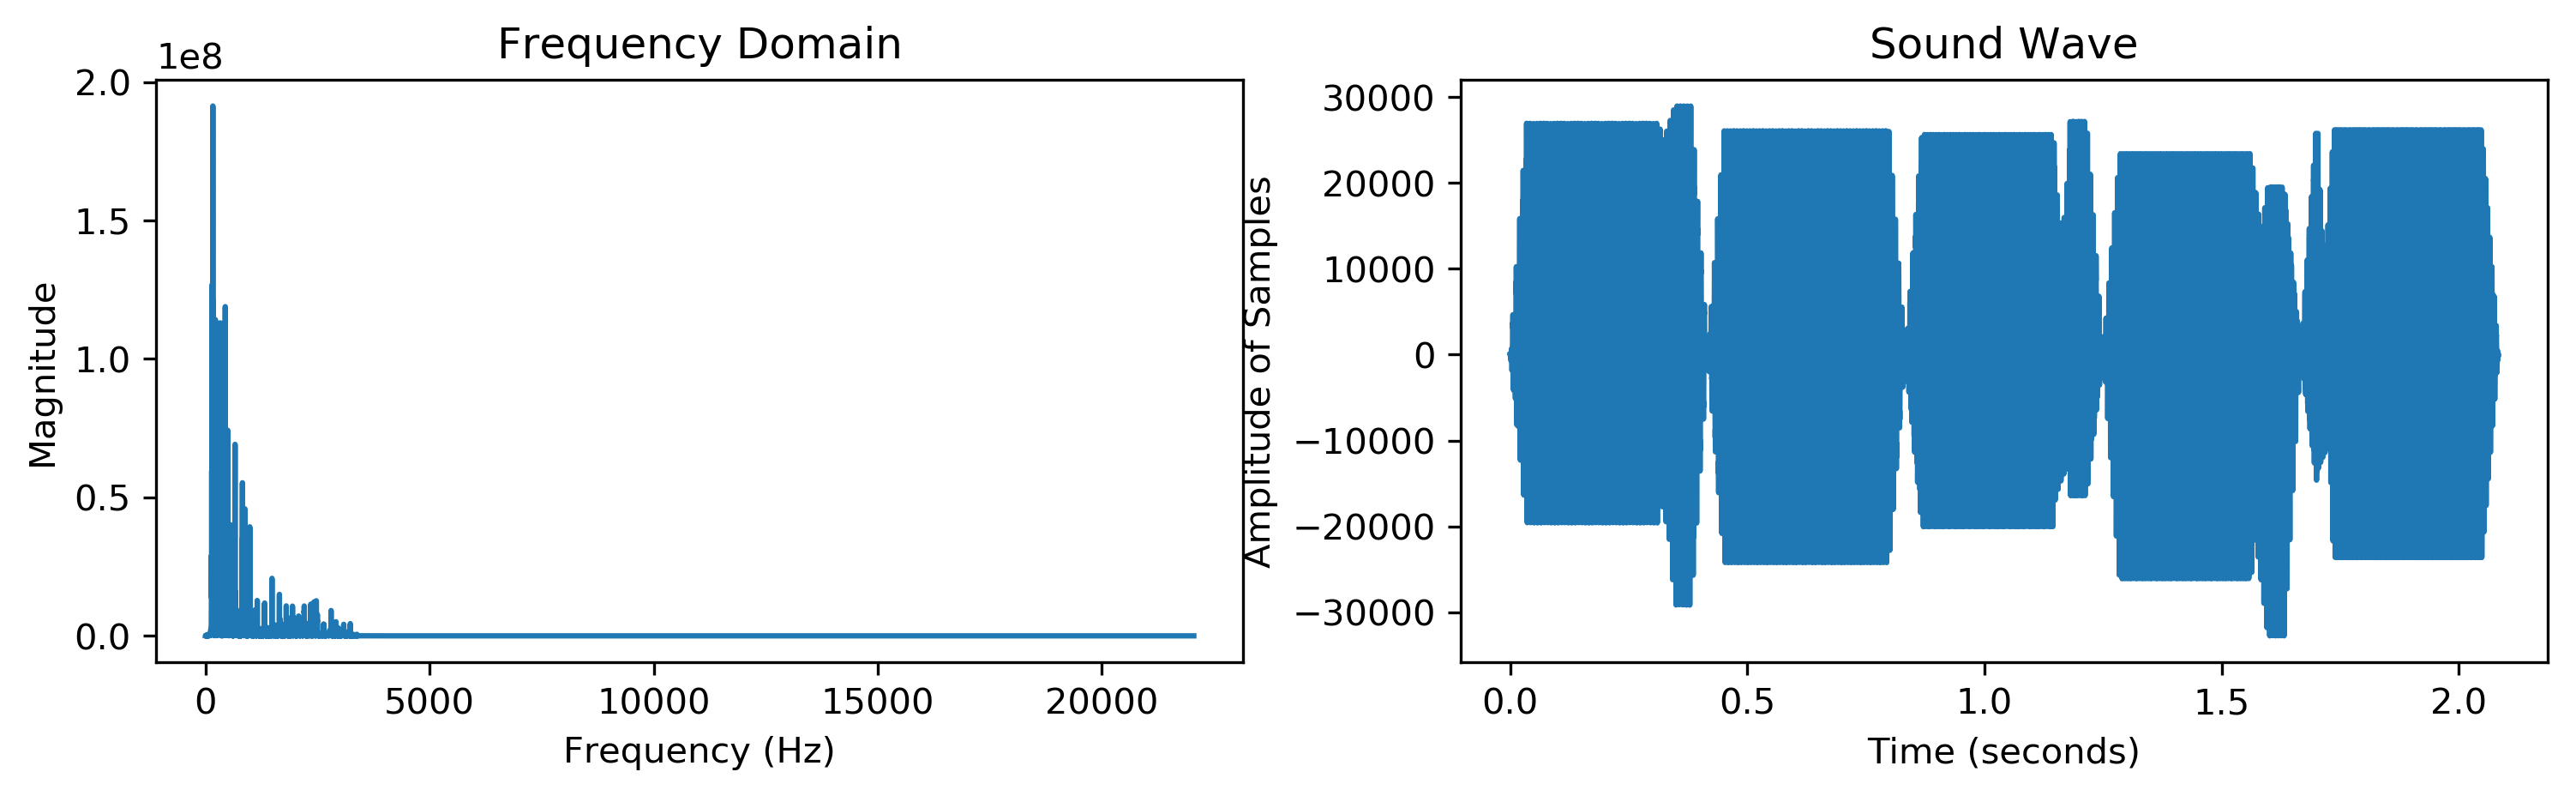

In [14]:
tempo = 144
tracks = [
            ['voice', ('c#3',(1,('','ey','ee'))), ('d3',(1,('','ee'))), ('e3',(1,('','aa','ih'))), \
             ('e3',(1,('','oh','uu'))), ('a3',(1,('ee','uu'))) ]
        ]
song = Compose(tempo, tracks)
song.soundwave.export("song.wav", True)
rate, samples = wavfile.read('song.wav')
vo = SoundWave(rate, samples[:])
vo.plot(True)

# IPython.display.Audio("song.wav")

In [15]:
# vwl2 =    ['ee','ih','ey','eh','aa','ah','aw','oh','oo','uu','uh','er']
# vwl2_f1 = [ 280, 370, 426, 610, 860, 838, 620, 567, 480, 328, 683, 514]
# vwl2_f2 = [2322,2090,1899,1850,1552,1173, 827, 910,1122, 807,1310,1319]
# vwl2_dict = {v:(f1,f2,(f2 + 4000)/2) for v,f1,f2 in zip(vwl2, vwl2_f1, vwl2_f2)}

ee
uu
(280, 2322, 3161.0)
(328, 807, 2403.5)


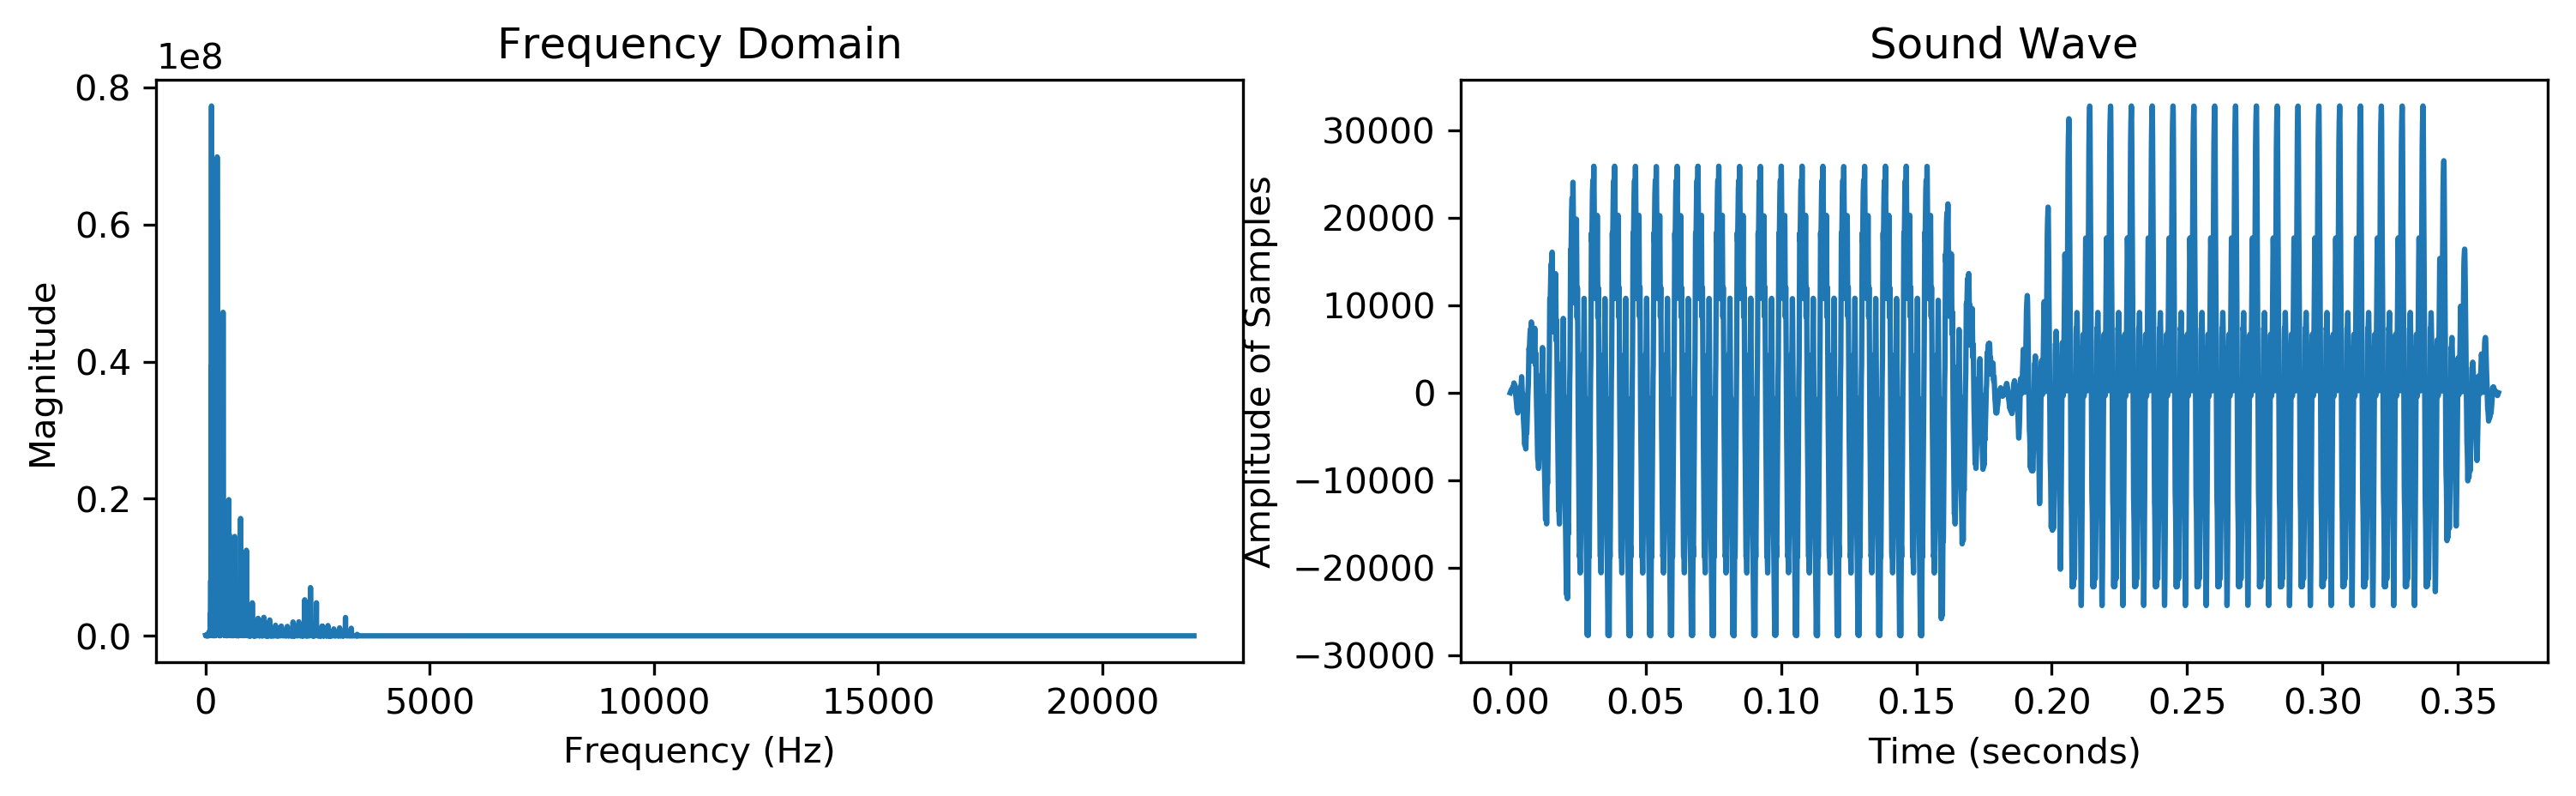

In [16]:
nn1 = 0
nn2 = 9
vow1 = vwl2[nn1]
vow2 = vwl2[nn2]
print(vow1)
print(vow2)
vow1 = vwl2_dict[vow1]
vow2 = vwl2_dict[vow2]
print(vow1)
print(vow2)
vo = generate_note(130, .1825, 'voice', other=vow1) >> generate_note(130, .1825, 'voice', other=vow2)

# Plot real and imag part of fft.
# mmm = len(vo.samples)
# vof = fft(vo.samples)
# plt.subplot(211)
# # plt.plot(np.arange(mmm//2),np.abs(vof)[:mmm//2])
# plt.plot(np.arange(mmm),vof.real)
# plt.subplot(212)
# plt.plot(np.arange(mmm),vof.imag)
# plt.show()

vo.export("voice130_i_ex.wav", True)
rate, samples = wavfile.read('voice130_i_ex.wav')
vo = SoundWave(rate, samples[:])
vo.plot(True)

# IPython.display.Audio("voice130_i_ex.wav")

In [17]:
vwl = vwl2
# Model 1 has height 2 and var 1.75
height = 5
var = 1.1
print('height: {}, var: {}:'.format(height,var))
print()
for nnn in range(len(vwl)):
    vow = vwl[nnn]
    print(vow)
    vow = vwl2_dict[vow]

    f1, f2, f3 = vow[0], vow[1], vow[2]
    y1 = lambda x: 1*(x - 3500)**2 / 3500**2 + 1
    y2 = lambda x1, x2: min([y1(x1), y1(x2)]) / 3 * (3500 - (x2 - x1)) / 3500

    # Set y values of f1,f2,f3,f12...
    yf1, yf2, yf3 = y1(f1), y1(f2), y1(f3)
    f12 = (f1 + f2)/2 + abs(yf1 - yf2)/max([yf1,yf2])*(f2 - f1)/2
    f23 = (f2 + f3)/2 + abs(yf2 - yf3)/max([yf2,yf3])*(f3 - f2)/2
    yf12, yf23 = y2(f1, f2), y2(f2, f3)
    # Set x values and y values
    print('f1, f2, f3:',f1, f2, f3)
    print('yf1, yf2, yf3:', yf1, yf2, yf3)
    print('f12, f23:',f12, f23)
    print('yf12, yf23:', yf12, yf23)

    min1 = min([(f12-f1), f1, 300])/var
    min2 = min([(f2-f12), (f23-f2), 300])/var
    min3 = min([(f3-f23), (3500-f3), 300])/var/3
    xx = np.array([min1 - f1, 0,
         f1 - min1, f1, f1 + min1, f12, 
         f2 - min2, f2, f2 + min2, f23,
         f3 - min3, f3, f3 + min3, 
         3500, 7000 - (f3 + min3)])
    yf11 = (yf1 + yf1*f1/f2)/height
    yf22 = (yf2 + yf2*f1/f2)/height
    yy = np.array([yf11, yf1, 
         yf11, yf1, yf11, yf12, 
         yf22, yf2, yf22, yf23, 
         yf3/3, yf3, yf3/3,
         0, yf3/3])
    domain = np.empty(0)
    image = np.empty(0)

    n_pts = 3
    for i in range(0,14,n_pts-1):
        xint = xx[i:i+n_pts]
        yint = yy[i:i+n_pts]
        domain = np.linspace(xint[0], xint[-1], int(xint[-1]-xint[0]), endpoint=False)
        domain[domain < 0] = domain[domain > 3500] = -1
        domain = domain[domain > 0]
        image = np.append(image, lagrange(xint, yint, domain))
    # print(image.shape)
    print('min, max:', min(image), max(image))
    
#     plt.plot(np.arange(len(image)), image)
#     plt.show()


height: 5, var: 1.1:

ee
f1, f2, f3: 280 2322 3161.0
yf1, yf2, yf3: 1.8464 1.1132803265306122 1.009381306122449
f12, f23: 1706.3916738584517 2780.6506415972094
yf12, yf23: 0.15458692534110788 0.2558060624373178
min, max: 0.0 1.846394470493352
ih
f1, f2, f3: 370 2090 3045.0
yf1, yf2, yf3: 1.79974693877551 1.1622938775510203 1.0169
f12, f23: 1534.6037311368038 2627.231517021232
yf12, yf23: 0.19703648590864914 0.24647719047619043
min, max: 0.0 1.7997423059181623
ey
f1, f2, f3: 426 1899 2949.5
yf1, yf2, yf3: 1.7713857959183672 1.2092408979591838 1.0247387959183674
f12, f23: 1396.2264520811468 2504.3909622023966
yf12, yf23: 0.2334410762060253 0.23905692196209913
min, max: 4.0444633204631897e-07 1.7713812924787922
eh
f1, f2, f3: 610 1850 2925.0
yf1, yf2, yf3: 1.6818040816326532 1.2222448979591838 1.0269897959183674
f12, f23: 1399.4172924119387 2473.3662756720655
yf12, yf23: 0.26307366375121477 0.23718573858114675
min, max: 0.0 1.68179992529866
aa
f1, f2, f3: 860 1552 2776.0
yf1, yf2, yf3: 1.

    Vowel frequencies from:
    https://en.wikipedia.org/wiki/Formant
    retrieved 4/19/19 2:30 am

    squillo:
    2-5 khz, 2.8-3.4 khz, ~3 khz

    Vowel IPA | Formant F1 | Formant F2 | Difference F1 - F2
    i   ee    | 240        | 2400       | 2160
    y   ye    | 235        | 2100       | 1865
    e   ey    | 390        | 2300       | 1910
    o/  ??    | 370        | 1900       | 1530
    eps eh    | 610        | 1900       | 1290
    oe  ??    | 585        | 1710       | 1125
    a   aa    | 850        | 1610       | 760
    OE  ??    | 820        | 1530       | 710
    \a  aw    | 750        | 940        | 190
    \/a oa    | 700        | 760        | 60
    ^   uh    | 600        | 1170       | 570
    \/c ??    | 500        | 700        | 200
    gam er    | 460        | 1310       | 850
    o   oh    | 360        | 640        | 280
    \/m oo    | 300        | 1390       | 1090
    u   ou    | 250        | 595        | 345
    
    https://www.researchgate.net/figure/Average-formant-frequencies-of-F1-and-F2-for-American-English-vowels-as-reported-in-67_tbl1_279164505
    Vowel | men women | men women
    ee    | 342-437   | 2322-2761
    ih    | 427-483   | 2034-2365
    ey    | 476-536   | 2089-2530
    eh    | 580-731   | 1799-2058
    aa    | 588-669   | 1952-2349
    ah    | 768-936   | 1333-1551
    aw    | 652-781   | 997 -1136
    oh    | 497-555   | 910 -1035
    oo    | 469-519   | 1122-1225
    uu    | 378-459   | 997 -1105
    uh    | 623-753   | 1200-1426
    er    | 474-523   | 1379-1588
    
    https://home.cc.umanitoba.ca/~krussll/phonetics/acoustic/formants.html
    Vowel | F1 | F2
    ee    | 280   | 2230
    ih    | 370   | 2090
    ey    | 405   | 2080
    eh    | 600   | 1930
    aa    | 860   | 1550
    ah    | 830   | 1170
    aw    | 560   | 820 
    oh    | 430   | 980 
    oo    | 400   | 1100
    uu    | 330   | 1260
    uh    | 680   | 1310